In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import pickle

In [2]:
# ---------- Helper Functions: box uncertainty set & weighting factor ----------

# 1. Construct the box-shaped uncertainty set Ξ (axis-aligned hyper-rectangle)
def build_box_uncertainty(Z_all, qmin=0.01, qmax=0.99, eta=0.02):
    """return [ell, upp] in each dimension of Z_all"""
    low  = np.quantile(Z_all, qmin, axis=0)
    high = np.quantile(Z_all, qmax, axis=0)
    span = high - low
    ell  = low  - eta * span
    upp  = high + eta * span
    # Avoid zero-width intervals
    upp = np.maximum(upp, ell + 1e-10)
    return ell, upp

def build_box_conic_from_bounds(ell, upp, n):
    """
    Rewrite the box uncertainty set  Ξ = { (x,y): ell <= (x,y) <= upp }
    into the form C1 x + c2 y <= d   (C is the nonnegative orthant cone), for direct use of Corollary 3.3.
    Return C1 (m*n), c2 (m,), d (m,), where m = 2*(n+1)
    where n = dim(x), y is a scalar
    """
    m = 2*(n+1)
    C1 = np.zeros((m, n))
    c2 = np.zeros(m)
    d  = np.zeros(m)

    row = 0
    # upper bound： x_j <= upp_j
    for j in range(n):
        C1[row, j] = 1.0
        d[row] = upp[j]
        row += 1
    # lower bound： -x_j <= -ell_j
    for j in range(n):
        C1[row, j] = -1.0
        d[row] = -ell[j]
        row += 1
    # upper bound for y： y <= upp_y
    c2[row] = 1.0
    d[row] = upp[n]
    row += 1
    # lower bound for y： -y <= -ell_y
    c2[row] = -1.0
    d[row] = -ell[n]
    row += 1

    assert row == m
    return C1, c2, d

# 2a. Compute time-dependent sample weights (exponential forgetting)
def time_weights_from_indices(time_idx, now_t, decay):
    raw = decay ** (now_t - time_idx)
    pi = raw / raw.sum()
    return pi

# 2b. Optimal weights according to Proposition 2 (for p = 1)
def optimal_weights_prop2(T, eps_over_rho):
    """
    Proposition 2 optimal weights for p = 1:
    - T = history length
    - eps_over_rho = ε/ρ in the paper, where eps in our code is ambuiguity radius, rho is the wasserstein distance between Pt and Pt+1
    Return weights w of length T
    """

    # s = floor(eps / rho)
    s = int(np.floor(eps_over_rho))
    s = max(1, min(s, T))  # truncate to [1, T]
    
    w = np.zeros(T)
    denom = s * (2 * eps_over_rho - s - 1)
    
    for t in range(T - s, T):
        # t runs from T-s to T-1  (0-index)
        w[t] = 2 * ((eps_over_rho) + (t+1) - T - 1) / denom

    return w

# 3. DRO ε-insensitive SVR
# ---------- Core：DRO-SVR following Corollary 3.3 ----------
def solve_dro_svr_cor33(X, y, C1, c2, d, pi, epsilon=1.0, rho=0.5, use_mosek=True):
    """
    Corollary 3.3 (Support Vector Regression):
      min   λ ρ + sum_i π_i s_i
      s.t.  y_i - <w,x_i> - ε + <p_i^+, d - C1 x_i - c2 y_i> <= s_i
            <w,x_i> - y_i - ε + <p_i^-, d - C1 x_i - c2 y_i> <= s_i
            || ( C1^T p_i^+ + w ,  c2^T p_i^+ - 1 ) ||_* <= λ
            || ( C1^T p_i^- - w ,  c2^T p_i^- + 1 ) ||_* <= λ
            p_i^+, p_i^- >= 0,  s_i >= 0
    """
    N, n = X.shape
    m = C1.shape[0]  # number of constraints (2*(n+1))

    w   = cp.Variable(n)
    lam = cp.Variable(nonneg=True)
    s   = cp.Variable(N, nonneg=True)

    constraints = []

    # pre-calculate (d - C1 x_i - c2 y_i) for each sample
    D_minus_Axi_cy = (d[None, :] - X @ C1.T - np.outer(y, c2))  # (N,m)

    for i in range(N):
        p_plus_i  = cp.Variable(m, nonneg=True)
        p_minus_i = cp.Variable(m, nonneg=True)

        # y_i - <w,x_i> - ε + <p_i^+, ...> <= s_i
        lhs1_i = (y[i] - X[i] @ w - epsilon + p_plus_i @ D_minus_Axi_cy[i, :])
        constraints += [lhs1_i <= s[i]]

        # <w,x_i> - y_i - ε + <p_i^-, ...> <= s_i
        lhs2_i = (X[i] @ w - y[i] - epsilon + p_minus_i @ D_minus_Axi_cy[i, :])
        constraints += [lhs2_i <= s[i]]

        # || ( C1^T p_i^+ + w ,  c2^T p_i^+ - 1 ) ||_2 <= λ
        # || ( C1^T p_i^- - w ,  c2^T p_i^- + 1 ) ||_2 <= λ
        vec_minus = cp.hstack([C1.T @ p_minus_i - w,  c2 @ p_minus_i + 1.0])
        vec_plus = cp.hstack([C1.T @ p_plus_i + w,  c2 @ p_plus_i - 1.0])

        constraints += [
            cp.norm(vec_plus,  'inf') <= lam,
            cp.norm(vec_minus, 'inf') <= lam
        ]

    # objective：λ ρ + sum_i π_i s_i
    pi_param = cp.Parameter(N, nonneg=True, value=np.asarray(pi, float))
    obj = cp.Minimize(lam * rho + pi_param @ s)

    prob = cp.Problem(obj, constraints)
    try:
        prob.solve(solver=cp.MOSEK if use_mosek else cp.ECOS, verbose=False)
    except cp.SolverError:
        prob.solve(solver=cp.ECOS, verbose=False)

    return w.value, prob.status

# 4. Empirical ε-insensitive SVR (no regularization, time-weighted)
def solve_empirical_svr_noreg(X, y, epsilon=1.0, sample_weights=None, use_mosek=True):
    N, n = X.shape
    w = cp.Variable(n)
    resid = y - X @ w
    loss  = cp.pos(cp.abs(resid) - epsilon)  # max(0, |r|-ε)

    if sample_weights is None:
        obj = cp.Minimize(cp.sum(loss) / N)
    else:
        sw = cp.Parameter(N, nonneg=True, value=np.asarray(sample_weights, float))
        weighted_loss = cp.sum(cp.multiply(sw, loss))
        obj = cp.Minimize(weighted_loss)

    prob = cp.Problem(obj)
    try:
        prob.solve(solver=cp.MOSEK if use_mosek else cp.ECOS, verbose=False)
    except cp.SolverError:
        prob.solve(solver=cp.ECOS, verbose=False)
    return w.value, prob.status

# 5. ε-insensitive loss
def eps_ins_loss(y_true, y_pred, eps):
    return np.maximum(0, np.abs(y_true - y_pred) - eps)

In [3]:
def load_real_excel_dataset(path):
    df = pd.read_excel(path)

    if 'No' in df.columns:
        df = df.drop(columns=['No'])

    data = df.values
    X = data[:, :-1].astype(float)
    y = data[:, -1].astype(float)

    X1 = X[:, 0]
    year = np.floor(X1).astype(int)
    month_float = np.round((X1 - year) * 12).astype(int)
    month = np.clip(month_float, 1, 12)

    year_min = year.min()
    time_index = (year - year_min) * 12 + (month - 1)

    X[:, 0] = time_index

    y_m2 = y / 3.3

    return X, y_m2, time_index

X_raw, y_real, time_index_all = load_real_excel_dataset("Real estate valuation data set.xlsx")


In [4]:
order = np.argsort(time_index_all)

time_sorted = time_index_all[order]
X_sorted_full = X_raw[order]
y_sorted = y_real[order]

X_features_sorted = X_sorted_full[:, 1:]

all_times = np.unique(time_sorted.astype(int))
T_total = len(all_times)

# ================================
# 0. hyperparameter grid
# ================================
epsilon = 0.5
time_ratios = [0.6, 0.7, 0.8, 0.9]
rho_list = np.logspace(-4, 1, num=10)
decay_list = [0.65, 0.75, 0.85, 0.95]
eps_over_rho_list = [1.1, 4, 7, 10, 12]

results = {
    "ratio": [],

    "SAA_mean": [],   "SAA_sem": [],
    "W-SAA_mean": [], "W-SAA_sem": [],
    "WDRO_mean": [],  "WDRO_sem": [],
    "Prop2_mean": [],"Prop2_sem": []
}

for ratio in time_ratios:
    T_cut = int(ratio * T_total)

    train_times = all_times[:T_cut]
    test_times  = all_times[T_cut:]

    train_mask = np.isin(time_sorted.astype(int), train_times)
    test_mask  = np.isin(time_sorted.astype(int), test_times)

    X_train = X_features_sorted[train_mask]
    y_train = y_sorted[train_mask]

    X_test  = X_features_sorted[test_mask]
    y_test  = y_sorted[test_mask]

    print(f"\n=== Time ratio {ratio:.1f} ===")
    print("Train months:", train_times[0], "→", train_times[-1])
    print("Test  months:",  test_times[0],  "→", test_times[-1])
    print("Train samples:", X_train.shape[0])
    print("Test  samples:", X_test.shape[0])

    # ================================
    # 1. pre-construct index by month
    # ================================
    time_train = time_sorted[train_mask].astype(int)
    unique_times, inv_idx = np.unique(time_train, return_inverse=True)

    T_time = len(unique_times)

    # number of samples in each month
    counts = np.bincount(inv_idx)

    # ================================
    # 2. construct Box uncertainty set
    # ================================
    Z_train = np.hstack([X_train, y_train[:, None]])

    ell, upp = build_box_uncertainty(Z_train, qmin=0.01, qmax=0.99, eta=0.02)
    C1, c2, d = build_box_conic_from_bounds(ell, upp, X_train.shape[1])

    # ================================
    # 3. empirical SAA
    # ================================
    w_saa, _ = solve_empirical_svr_noreg(
        X_train, y_train,
        epsilon=epsilon,
        sample_weights=None
    )

    y_pred_saa = X_test @ w_saa
    err_saa = eps_ins_loss(y_test, y_pred_saa, epsilon)

    loss_saa_mean = err_saa.mean()
    loss_saa_sem  = err_saa.std(ddof=1) / np.sqrt(len(err_saa))

    print("empirical SAA loss:", loss_saa_mean, "±", loss_saa_sem)

    # ================================
    # 4. W-SAA
    # ================================
    best_wsaa_loss = np.inf
    best_wsaa_sem  = None
    best_wsaa_decay = None
    best_w_wsaa = None

    for decay in decay_list:
        time_idx_month = np.arange(T_time)
        pi_time_wsaa = time_weights_from_indices(
            time_idx_month,
            now_t=T_time - 1,
            decay=decay
        )

        pi_wsaa_samples = pi_time_wsaa[inv_idx] / counts[inv_idx]
        pi_wsaa_samples = pi_wsaa_samples / pi_wsaa_samples.sum()

        w_wsaa, _ = solve_empirical_svr_noreg(
            X_train, y_train,
            epsilon=epsilon,
            sample_weights=pi_wsaa_samples
        )

        y_pred = X_test @ w_wsaa
        err = eps_ins_loss(y_test, y_pred, epsilon)
        loss_mean = err.mean()
        loss_sem  = err.std(ddof=1) / np.sqrt(len(err))

        if loss_mean < best_wsaa_loss:
            best_wsaa_loss = loss_mean
            best_wsaa_sem  = loss_sem
            best_wsaa_decay = decay
            best_w_wsaa = w_wsaa

    print("Best W-SAA loss:", best_wsaa_loss, "±", best_wsaa_sem, " | decay =", best_wsaa_decay)

    # ================================
    # 5. Weighted DRO-SVR
    # ================================
    best_wdro_loss = np.inf
    best_wdro_sem  = None
    best_wdro_rho = None
    best_wdro_decay = None
    best_w_wdro = None

    for decay in decay_list:
        time_idx_month = np.arange(T_time)
        pi_time_wdro = time_weights_from_indices(
            time_idx_month,
            now_t=T_time - 1,
            decay=decay
        )

        pi_wdro_samples = pi_time_wdro[inv_idx] / counts[inv_idx]
        pi_wdro_samples = pi_wdro_samples / pi_wdro_samples.sum()

        for rho in rho_list:
            w_wdro, _ = solve_dro_svr_cor33(
                X_train, y_train,
                C1, c2, d,
                pi_wdro_samples,
                epsilon=epsilon,
                rho=rho
            )

            y_pred = X_test @ w_wdro
            err = eps_ins_loss(y_test, y_pred, epsilon)
            loss_mean = err.mean()
            loss_sem  = err.std(ddof=1) / np.sqrt(len(err))

            if loss_mean < best_wdro_loss:
                best_wdro_loss = loss_mean
                best_wdro_sem  = loss_sem
                best_wdro_rho = rho
                best_wdro_decay = decay
                best_w_wdro = w_wdro

    print(
        "Best Weighted-DRO loss:", best_wdro_loss, "±", best_wdro_sem,
        " | rho =", best_wdro_rho,
        " | decay =", best_wdro_decay
    )

    # ================================
    # 6. Prop2 Optimal Weights + DRO-SVR
    # ================================
    best_prop2_loss = np.inf
    best_prop2_sem  = None
    best_prop2_rho = None
    best_prop2_driftbound = None
    best_w_prop2 = None

    for rho in rho_list:
        for eps_over_rho in eps_over_rho_list:
            pi_time_prop2 = optimal_weights_prop2(T_time, eps_over_rho)
            pi_time_prop2 = pi_time_prop2 / pi_time_prop2.sum()

            pi_prop2_samples = pi_time_prop2[inv_idx] / counts[inv_idx]
            pi_prop2_samples = pi_prop2_samples / pi_prop2_samples.sum()

            w_prop2, _ = solve_dro_svr_cor33(
                X_train, y_train,
                C1, c2, d,
                pi_prop2_samples,
                epsilon=epsilon,
                rho=rho
            )

            y_pred = X_test @ w_prop2
            err = eps_ins_loss(y_test, y_pred, epsilon)
            loss_mean = err.mean()
            loss_sem  = err.std(ddof=1) / np.sqrt(len(err))

            if loss_mean < best_prop2_loss:
                best_prop2_loss = loss_mean
                best_prop2_sem  = loss_sem
                best_prop2_rho = rho
                best_prop2_epsrho = eps_over_rho
                best_w_prop2 = w_prop2

    print(
        "Best Prop2-DRO loss:", best_prop2_loss, "±", best_prop2_sem,
        " | rho =", best_prop2_rho,
        " | eps_over_rho =", best_prop2_epsrho
    )

    results["ratio"].append(ratio)

    results["SAA_mean"].append(loss_saa_mean)
    results["SAA_sem"].append(loss_saa_sem)

    results["W-SAA_mean"].append(best_wsaa_loss)
    results["W-SAA_sem"].append(best_wsaa_sem)

    results["WDRO_mean"].append(best_wdro_loss)
    results["WDRO_sem"].append(best_wdro_sem)

    results["Prop2_mean"].append(best_prop2_loss)
    results["Prop2_sem"].append(best_prop2_sem)


=== Time ratio 0.6 ===
Train months: 7 → 13
Test  months: 14 → 18
Train samples: 225
Test  samples: 189
empirical SAA loss: 1.6943710946103547 ± 0.18011932606688072
Best W-SAA loss: 1.694033204406853 ± 0.17910556046275006  | decay = 0.75
Best Weighted-DRO loss: 1.6962883065380745 ± 0.17976956130041763  | rho = 0.00035938136638046257  | decay = 0.65
Best Prop2-DRO loss: 1.697216867569579 ± 0.17818776820938748  | rho = 0.001291549665014884  | eps_over_rho = 4

=== Time ratio 0.7 ===
Train months: 7 → 14
Test  months: 15 → 18
Train samples: 257
Test  samples: 157
empirical SAA loss: 1.7345043434517542 ± 0.2085587013198912
Best W-SAA loss: 1.7717366842729723 ± 0.2087944057048998  | decay = 0.95
Best Weighted-DRO loss: 1.786841463186926 ± 0.21167020209891324  | rho = 0.00035938136638046257  | decay = 0.95
Best Prop2-DRO loss: 1.7926063894247184 ± 0.2121064182334506  | rho = 0.00035938136638046257  | eps_over_rho = 12

=== Time ratio 0.8 ===
Train months: 7 → 15
Test  months: 16 → 18
Train 

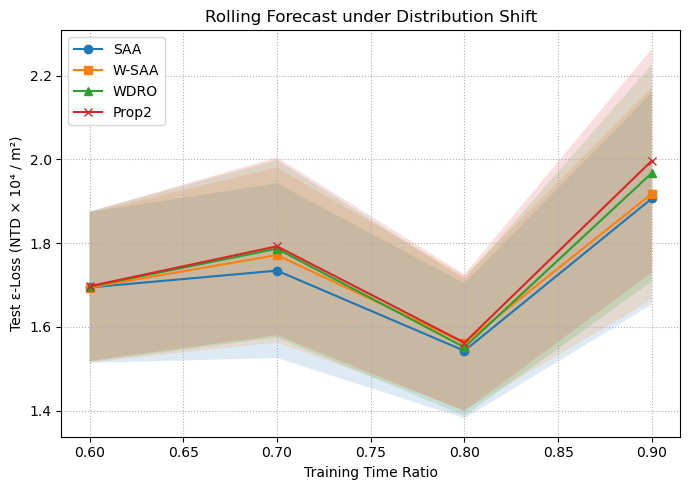

In [5]:
ratios = np.array(results["ratio"])

plt.figure(figsize=(7,5))

for name, marker in [("SAA","o"), ("W-SAA","s"), ("WDRO","^"), ("Prop2","x")]:
    mean = np.array(results[f"{name}_mean"])
    sem  = np.array(results[f"{name}_sem"])

    plt.plot(ratios, mean, marker=marker, label=name)
    plt.fill_between(ratios, mean - sem, mean + sem, alpha=0.15)

plt.xlabel("Training Time Ratio")
plt.ylabel("Test ε-Loss (NTD × 10⁴ / m²)")
plt.title("Rolling Forecast under Distribution Shift")
plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()